Base Algorithm

In [320]:
import numpy as np
import matplotlib.pyplot as plt

class Parameters:
    def __init__(self, b1, b2, k1, k2, c12, c21, z_m1_initial, z_m2_initial, initial_population_species_1, initial_population_species_2, cost_to_males, strength_of_interference, V_A1, V_A2, num_generations):
        self.b1 = b1
        self.b2 = b2
        self.k1 = k1
        self.k2 = k2
        self.c12 = c12
        self.c21 = c21
        self.z_m1_initial = z_m1_initial
        self.z_m2_initial = z_m2_initial
        self.initial_population_species_1 = initial_population_species_1
        self.initial_population_species_2 = initial_population_species_2
        self.cost_to_males = cost_to_males
        self.strength_of_interference = strength_of_interference
        self.V_A1 = V_A1
        self.V_A2 = V_A2
        self.num_generations = num_generations

class Simulation:
    def __init__(self, params):
        self.params = params
        self.population_species_history_1 = [params.initial_population_species_1]
        self.population_species_history_2 = [params.initial_population_species_2]
        self.z_m1_history = [params.z_m1_initial]
        self.z_m2_history = [params.z_m2_initial]
        self.z_m1 = params.z_m1_initial
        self.z_m2 = params.z_m2_initial

    def next_generation_ecology(self):
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]
        
        if N1 > 0.01:
            next_N1 = self.params.b1 * (N1 / 2) * (N1 / (N1 + self.params.strength_of_interference * (1 - self.z_m2) * N2)) - (self.params.k1 * N1 * (N1 + self.params.c12 * N2))
            next_N1 = max(next_N1, 0)
        else:
            next_N1 = 0 
        
        if N2 > 0.01:
            next_N2 = self.params.b2 * (N2 / 2) * (N2 / (N2 + self.params.strength_of_interference * (1 - self.z_m1) * N1)) - (self.params.k2 * N2 * (N2 + self.params.c21 * N1))
            next_N2 = max(next_N2, 0)
        else:
            next_N2 = 0

        self.population_species_history_1.append(next_N1)
        self.population_species_history_2.append(next_N2)

    def next_generation_traits(self, N1, N2):
        if N1 > 0:
            W_m1 = 1 - (self.params.cost_to_males * (1 - self.z_m1) * (N2 / (N2 + N1)))
            dW_m1_dz_m2 = self.params.cost_to_males * (N2 / (N2 + N1))
            delta_z_m1 = self.params.V_A1 * (1 / W_m1) * dW_m1_dz_m2
            new_z_m1 = self.z_m1 + delta_z_m1
            
            if new_z_m1 <= 1:
                self.z_m1 = new_z_m1

            self.z_m1_history.append(self.z_m1)

        if N2 > 0:
            W_m2 = 1 - (self.params.cost_to_males * (1 - self.z_m2) * (N2 / (N2 + N1)))
            dW_m2_dz_m2 = self.params.cost_to_males * (N1 / (N1 + N2))
            delta_z_m2 = self.params.V_A2 * (1 / W_m2) * dW_m2_dz_m2
            new_z_m2 = self.z_m2 + delta_z_m2
            
            if new_z_m2 <= 1:
                self.z_m2 = new_z_m2

            self.z_m2_history.append(self.z_m2)

    def next_generation(self):
        self.next_generation_ecology()
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]
        self.next_generation_traits(N1, N2)
        return N1, N2

    def run_simulation(self):
        for t in range(self.params.num_generations - 1):
            N1, N2 = self.next_generation()
            if N1 == 0 or N2 == 0:
                break

        return self.population_species_history_1, self.population_species_history_2, self.z_m1_history, self.z_m2_history

class outcome_stats_and_plots:
    def __init__(self, population_species_1, population_species_2, z_m1_history, z_m2_history, params):
        self.population_species_1 = population_species_1
        self.population_species_2 = population_species_2
        self.z_m1_history = z_m1_history
        self.z_m2_history = z_m2_history
        self.params = params

        self.outcome = None
        self.number_of_generations_until_extinctioin = None
        self.final_population_species_1 = None
        self.final_population_species_2 = None
        self.final_z_m1 = None
        self.final_z_m2 = None

        self.outcome_stats()

    def plot_population_dynamics_and_trait_evolution(self):
        plt.ion()
        self.plot_population_dynamics()
        self.plot_traits_evolution()

    def plot_population_dynamics(self):
        plt.ion()
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(self.population_species_1, label='Species 1')
        ax.plot(self.population_species_2, label='Species 2')
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        ax.set_title('Population Dynamics of Two Competing Species')
        ax.legend()
        ax.grid(True)
        plt.show()

    def plot_traits_evolution(self):
        plt.ion()
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(self.z_m1_history, label="Mean Trait z_m1")
        ax.plot(self.z_m2_history, label="Mean Trait z_m2")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Mean Trait Value")
        ax.set_title('Evolution of Traits')
        ax.legend()
        ax.grid(True)
        plt.show()


    def outcome_stats(self):

        if self.population_species_1[-1] == 0:
            self.outcome = 0
        elif self.population_species_2[-1] == 0:
            self.outcome = 1
        else:
            self.outcome = 2

        if len(self.population_species_1) < self.params.num_generations:
            self.number_of_generations_until_extinctioin = len(self.population_species_1)
            self.final_population_species_1 = self.population_species_1[-1]
            self.final_population_species_2 = self.population_species_2[-1]
            self.final_z_m1 = self.z_m1_history[-1]
            self.final_z_m2 = self.z_m2_history[-1]

    def print_outcome_stats(self):

        if self.outcome == 0:
            print("Species 1 (fast evolving) went extinct, slow evolving wins")
        if self.outcome == 1:
            print("Species 2 (slow evolving) went extinct, fast evolving wins") 
        if self.outcome == 2:   
            print("Both species coexisted until the end of the simulation")
            
        print("Number of generations until extinction: ", self.number_of_generations_until_extinctioin)
        print("Final population of species 1: ", self.final_population_species_1)
        print("Final population of species 2: ", self.final_population_species_2)
        print("Final trait value z_m1: ", self.final_z_m1)
        print("Final trait value z_m2: ", self.final_z_m2)

def run_simulation_and_plot_pop_dynamics_and_trait_evolution(outcome_stats_and_plots_instance):
    outcome_stats_and_plots_instance.plot_population_dynamics_and_trait_evolution()
    outcome_stats_and_plots_instance.print_outcome_stats()

def run_simulation_and_get_outcome_instance(params):
    simulation = Simulation(params)
    population_species_1, population_species_2, z_m1_history, z_m2_history = simulation.run_simulation()
    outcome_stats_and_plots_instance = outcome_stats_and_plots(population_species_1, population_species_2, z_m1_history, z_m2_history, params)
    
    return outcome_stats_and_plots_instance




Base Parameters Simulation

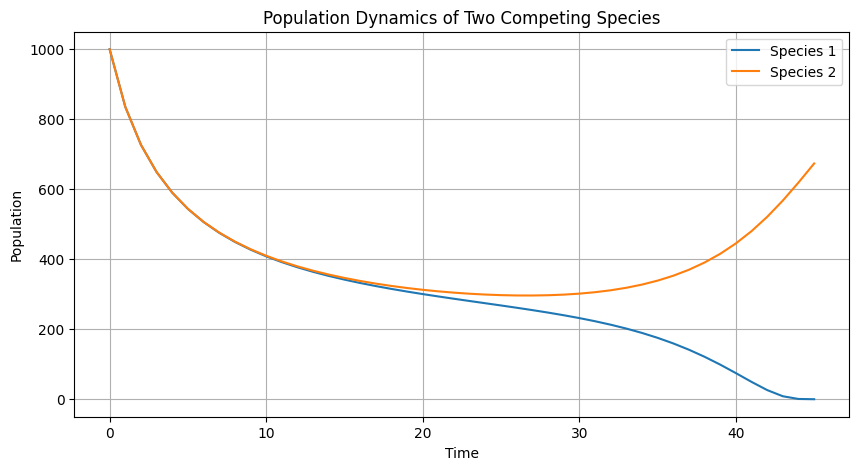

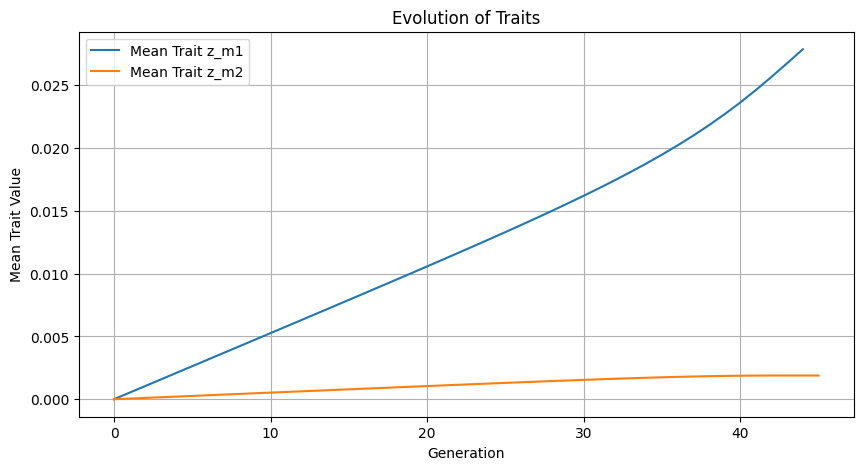

Species 1 (fast evolving) went extinct, slow evolving wins
Number of generations until extinction:  46
Final population of species 1:  0
Final population of species 2:  673.5988324483301
Final trait value z_m1:  0.02787089007538366
Final trait value z_m2:  0.0018888520751201804


In [321]:
# Parameters
base_parameters = Parameters(
    b1 = 2.3, 
    b2 = 2.3, 
    k1 = 0.0001, 
    k2 = 0.0001, 
    c12 = 1.1, 
    c21 = 1.1, 
    z_m1_initial = 0, 
    z_m2_initial = 0, 
    initial_population_species_1 = 1000, 
    initial_population_species_2 = 1000, 
    cost_to_males = 0.1,
    strength_of_interference = 0.1,
    V_A1 = 0.01, 
    V_A2 = 0.001, 
    num_generations = 10000
)

outcome_instance = run_simulation_and_get_outcome_instance(base_parameters)
outcome_instance.plot_population_dynamics_and_trait_evolution()
outcome_instance.print_outcome_stats()




Sensitivity Analysis


Running sensitivity analysis for b1...


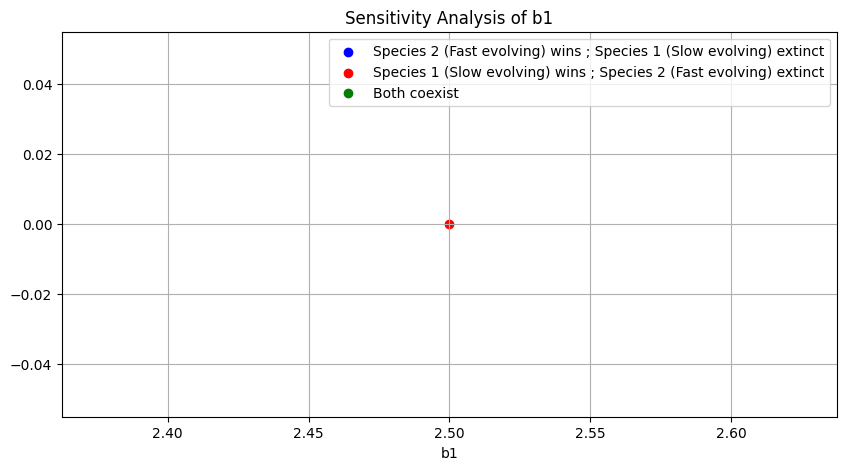

Running sensitivity analysis for b2...


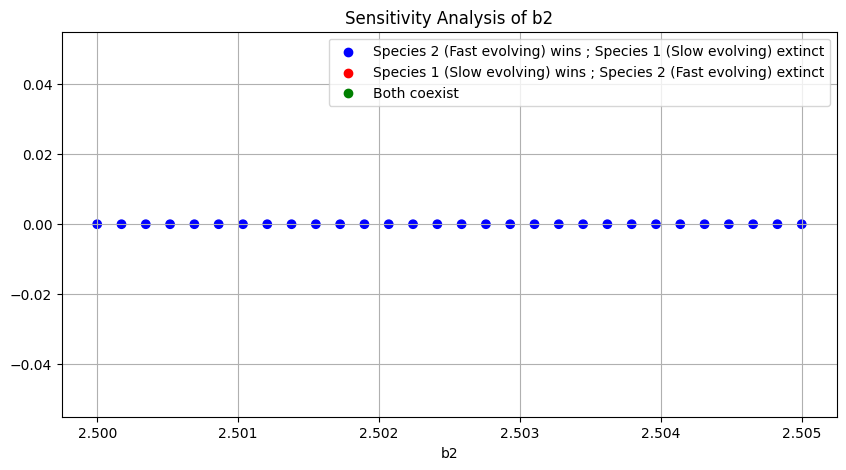

Running sensitivity analysis for k1...


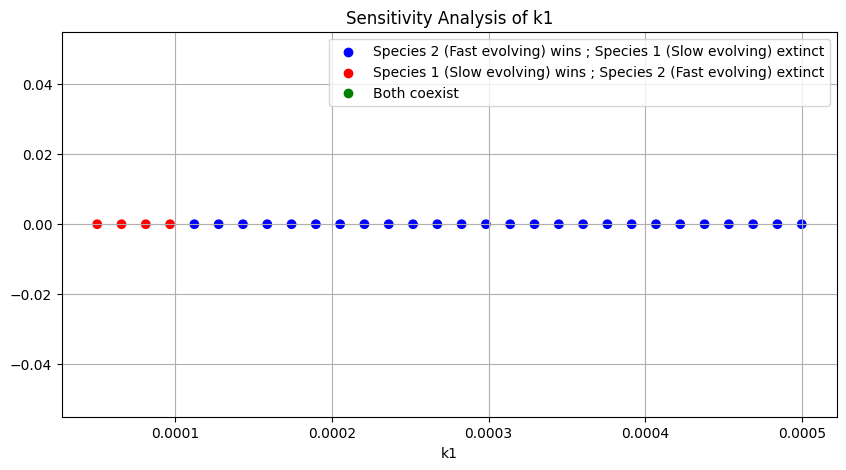

Running sensitivity analysis for k2...


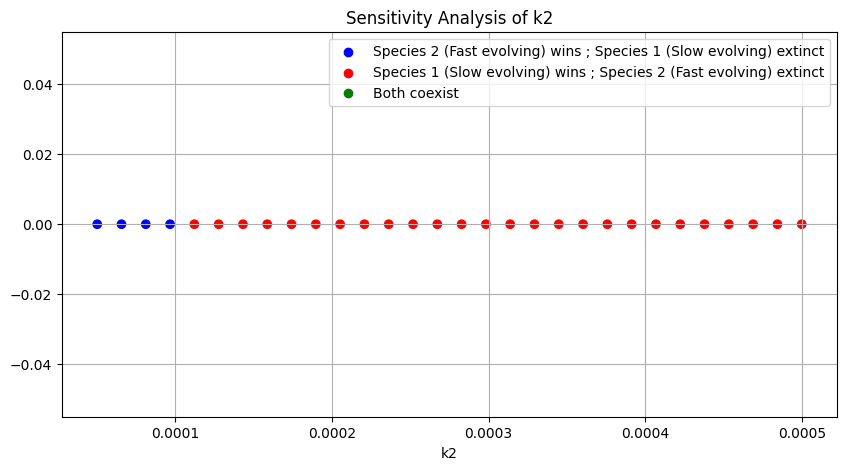

Running sensitivity analysis for c12...


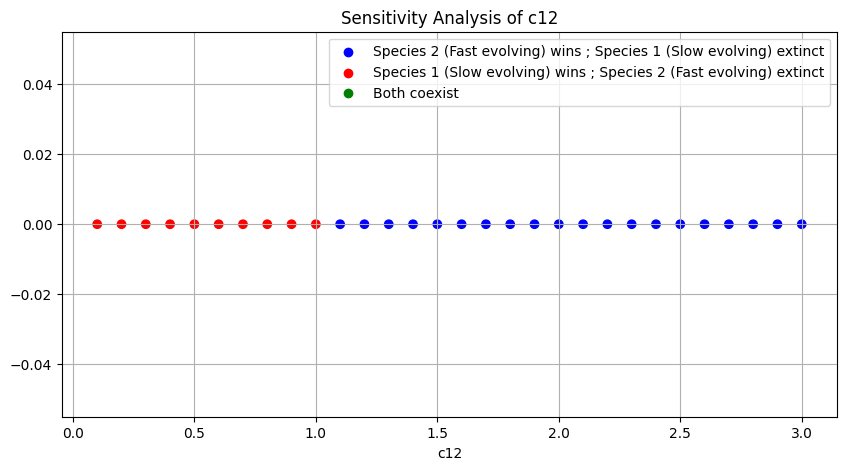

Running sensitivity analysis for c21...


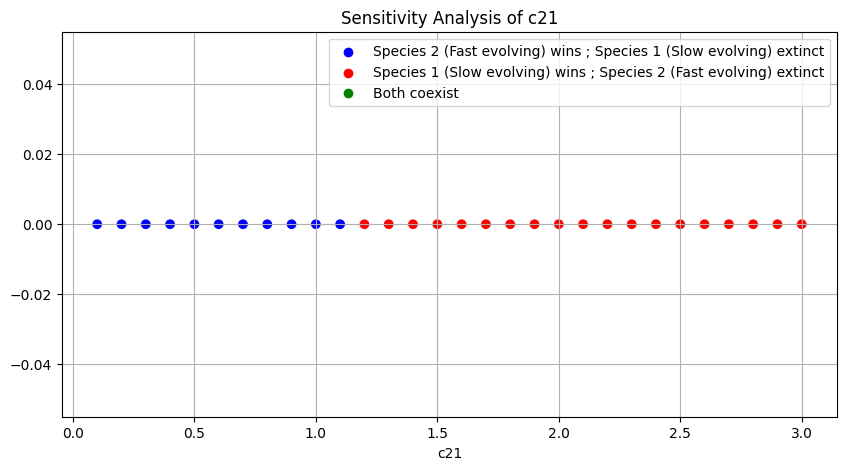

Running sensitivity analysis for z_m1_initial...


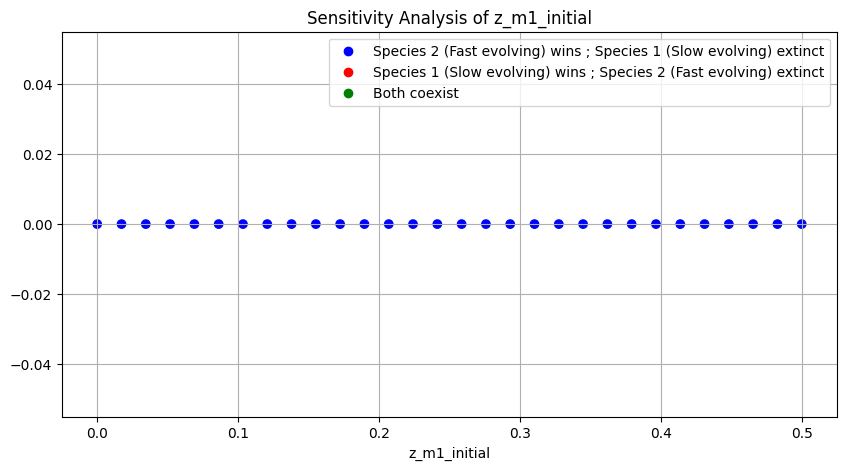

Running sensitivity analysis for z_m2_initial...


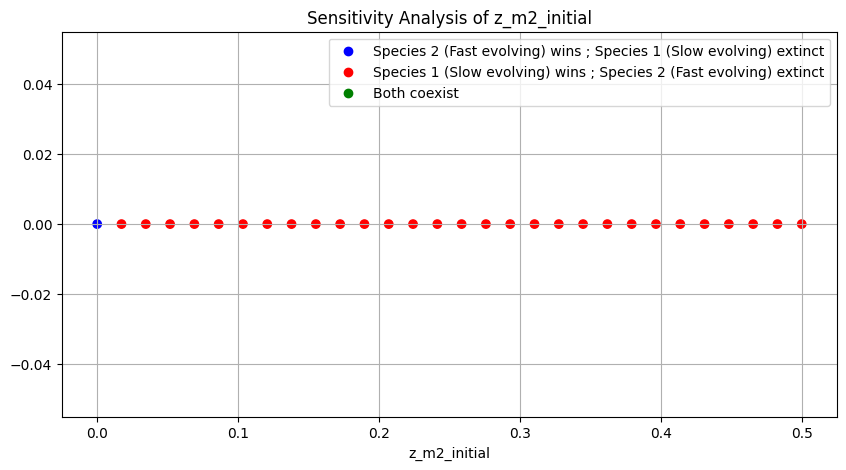

Running sensitivity analysis for cost_to_males...


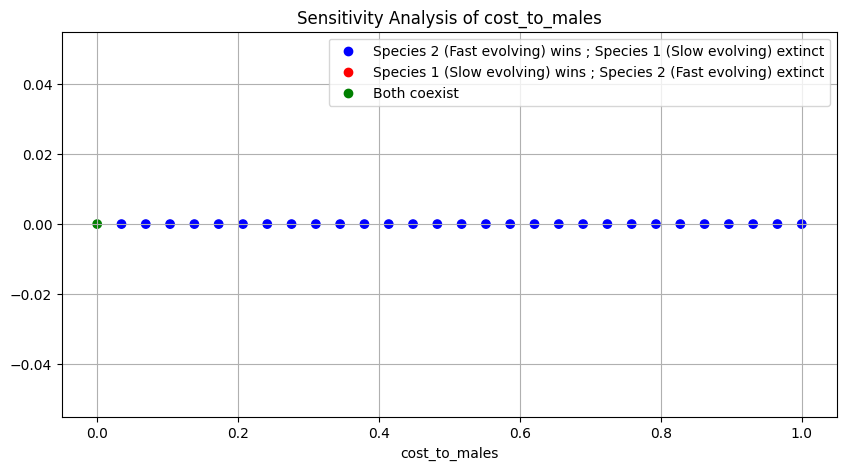

Running sensitivity analysis for strength_of_interference...


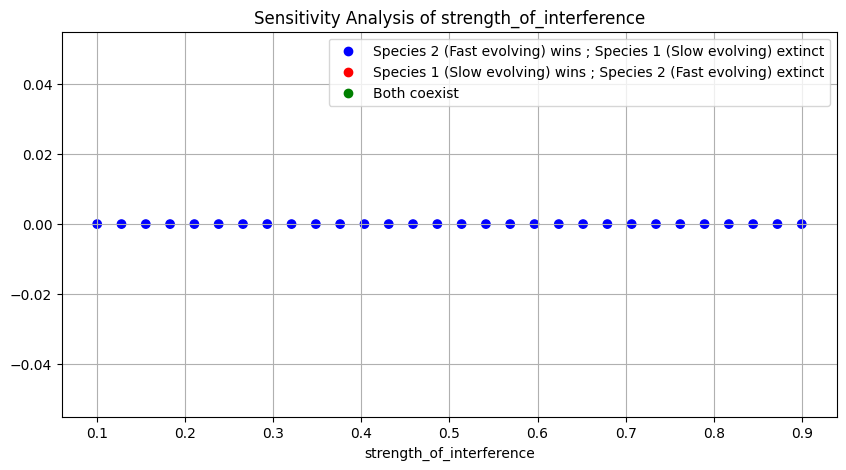

Running sensitivity analysis for V_A1...


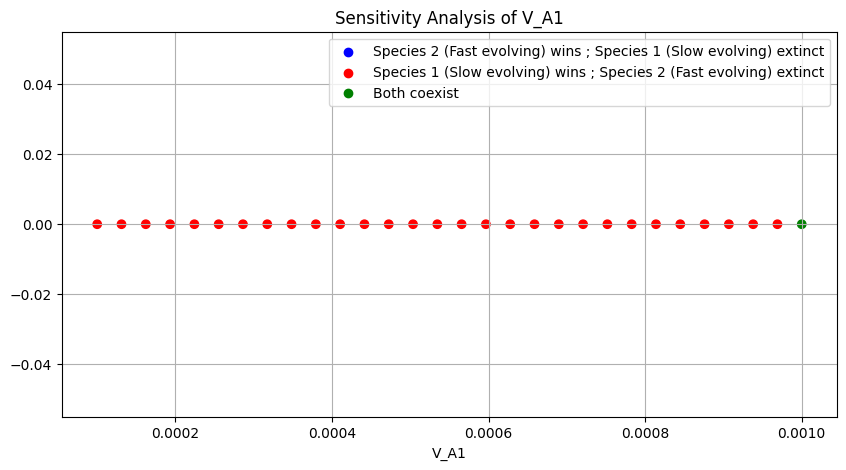

Running sensitivity analysis for V_A2...


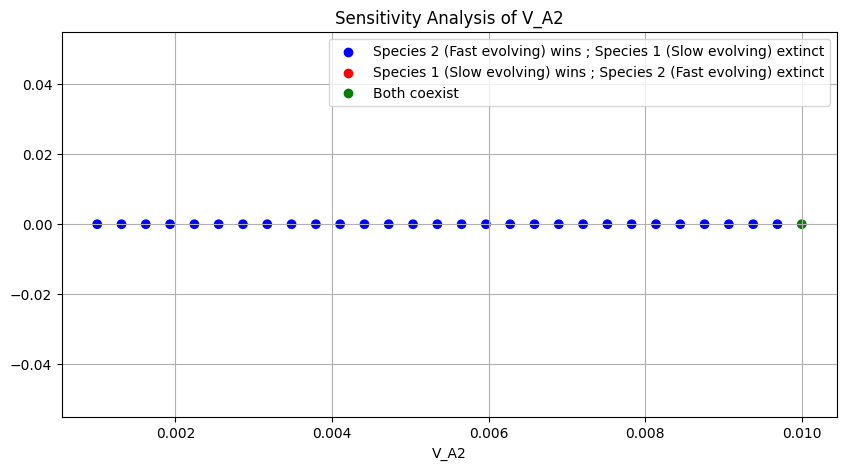

In [322]:
import numpy as np
import matplotlib.pyplot as plt

class Parameters_for_Analysis:
    def __init__(self, **kwargs):
        self.b1 = kwargs.get('b1', 2.3)
        self.b2 = kwargs.get('b2', 2.3)
        self.k1 = kwargs.get('k1', 0.0001)
        self.k2 = kwargs.get('k2', 0.0001)
        self.c12 = kwargs.get('c12', 1.1)
        self.c21 = kwargs.get('c21', 1.1)
        self.z_m1_initial = kwargs.get('z_m1_initial', 0)
        self.z_m2_initial = kwargs.get('z_m2_initial', 0)
        self.initial_population_species_1 = kwargs.get('initial_population_species_1', 1000)
        self.initial_population_species_2 = kwargs.get('initial_population_species_2', 1000)
        self.cost_to_males = kwargs.get('cost_to_males', 0.3)
        self.strength_of_interference = kwargs.get('strength_of_interference', 0.1)
        self.V_A1 = kwargs.get('V_A1', 0.001)
        self.V_A2 = kwargs.get('V_A2', 0.01)
        self.num_generations = kwargs.get('num_generations', 1000)

def plot_sensitivity_analysis(param_values, final_outcomes, param_name):
        color_map = {0: 'blue', 1: 'red', 2: 'green'}
        colors = [color_map[outcome] for outcome in final_outcomes]
        
        plt.figure(figsize=(10, 5))
        plt.scatter(param_values, [0]*len(param_values), color=colors, marker='o')
        plt.xlabel(param_name)
        plt.title(f'Sensitivity Analysis of {param_name}')
        plt.grid(True)
        # Adding legend manually
        plt.scatter([], [], color='blue', label='Species 2 (Fast evolving) wins ; Species 1 (Slow evolving) extinct')
        plt.scatter([], [], color='red', label='Species 1 (Slow evolving) wins ; Species 2 (Fast evolving) extinct')
        plt.scatter([], [], color='green', label='Both coexist')
        plt.legend(loc='upper right')
        plt.show()

def generate_parameters_with_varied_param(base_params, param_name, param_values):
    params_list = []
    for value in param_values:
        params_dict = vars(base_params).copy()
        params_dict[param_name] = value
        params = Parameters_for_Analysis(**params_dict)
        params_list.append(params)
    return params_list

def run_sensitivity_analysis(params_list):
    final_outcomes = []
    for params in params_list:
        final_outcome_instance = run_simulation_and_get_outcome_instance(params)
        final_outcomes.append(final_outcome_instance.outcome)
    return final_outcomes

def main():
    # Base Parameters

    # Parameters to vary
    param_names = ['b1', 'b2', 'k1', 'k2', 'c12', 'c21', 'z_m1_initial', 'z_m2_initial', 'cost_to_males', 'strength_of_interference', 'V_A1', 'V_A2']
    param_ranges = {
        'b1': [2.5],
        'b2': np.linspace(2.5, 2.505, 30),
        'k1': np.linspace(0.00005, 0.0005, 30),
        'k2': np.linspace(0.00005, 0.0005, 30),
        'c12': np.linspace(0.1, 3, 30),
        'c21': np.linspace(0.1, 3, 30),
        'z_m1_initial': np.linspace(0, 0.5, 30),
        'z_m2_initial': np.linspace(0, 0.5, 30),
        'cost_to_males': np.linspace(0, 1, 30),
        'strength_of_interference': np.linspace(0.1, 0.9, 30),
        'V_A1': np.linspace(0.0001, 0.001, 30),
        'V_A2': np.linspace(0.001, 0.01, 30)
    }

    for param_name in param_names:
        print(f"Running sensitivity analysis for {param_name}...")
        param_values = param_ranges[param_name]
        params_list = generate_parameters_with_varied_param(base_parameters, param_name, param_values)
        outcomes = run_sensitivity_analysis(params_list)
        plot_sensitivity_analysis(param_values, outcomes, param_name)

if __name__ == "__main__":
    main()


1. Okay, so birth rate is really important. If the population A has slightly better birth rate it will do better, with base parameters
2. + and - terms, birth rate is directly proprotional - negtaively affects things
3. Competition thinsg are more interesting, 
4. sensitivity analysis b2 - A very small difference in birth rate can make a huge difference in population numbrs. +0.02 is enough to make the fast evilving species win

k1 -- 0.0001, 0,0012 is - the fast species can win if k increases, i.e. its carrying capacity becomes smaller

k2 - either k2 becomes low, or k1 becomes high.  (0.0005 - 0.005)/30 x o.5

once again competetive differences - either increase c12 or decrease c21

if eithr enemy becomes a weaker competeor I become a stroneger


z1, z2 there will be funs stuff

I can add interesting angle to the work -- how will the results change if both are affected by

- create diff files

If V_A2 does not evolve coexistence is found!

In [254]:
x_list = [0,0.1, 0,3]
for x in x_list:
    params_temp = Parameters_for_Analysis(cost_to_males = x)
    outcome_stats_and_plots_instance_temp = run_simulation_and_get_outcome_instance(params_temp)
    print(var, "=", x, "|| number of generations until extinction = ", outcome_stats_and_plots_instance_temp.number_of_generations_until_extinctioin)



cost_to_males = 0 || number of generations until extinction =  None
cost_to_males = 0.1 || number of generations until extinction =  46
cost_to_males = 0 || number of generations until extinction =  None
cost_to_males = 3 || number of generations until extinction =  24


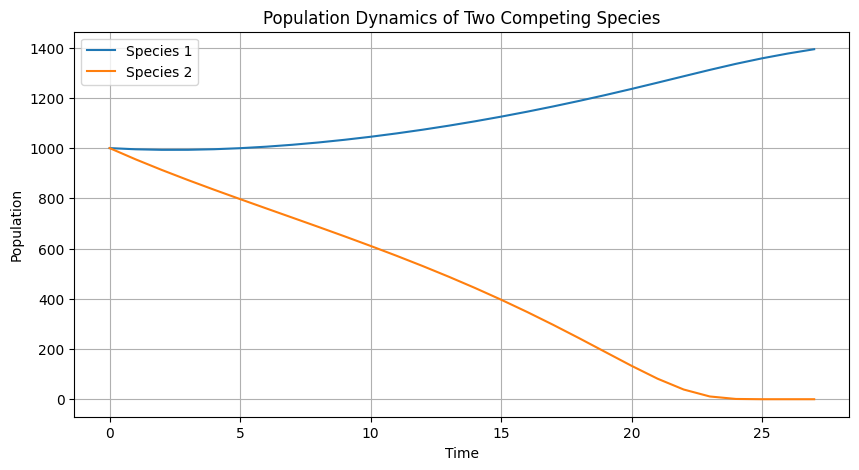

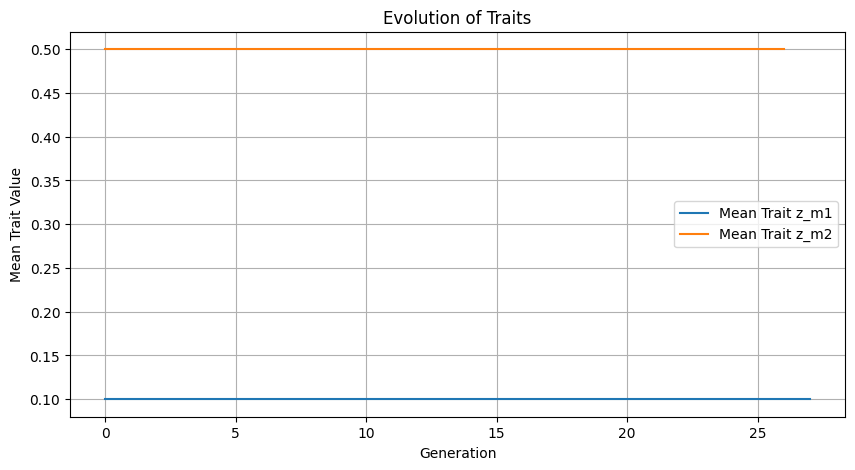

V_A1 = 0 | V_A2 =  0 || generations until extinction =  28


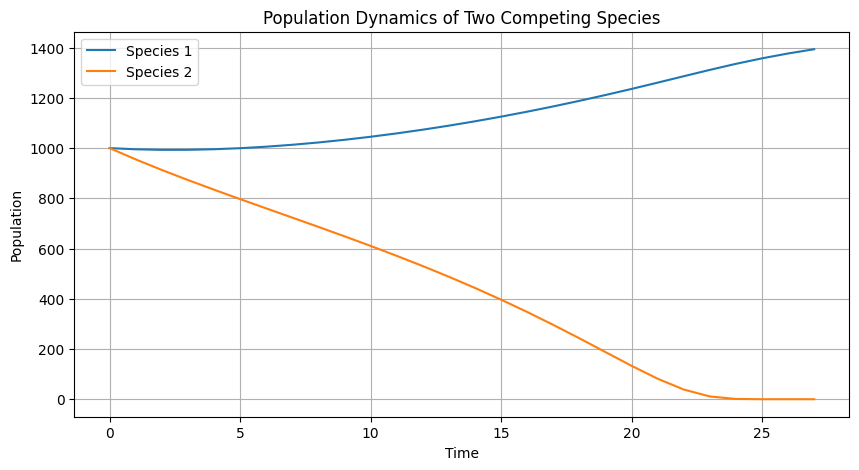

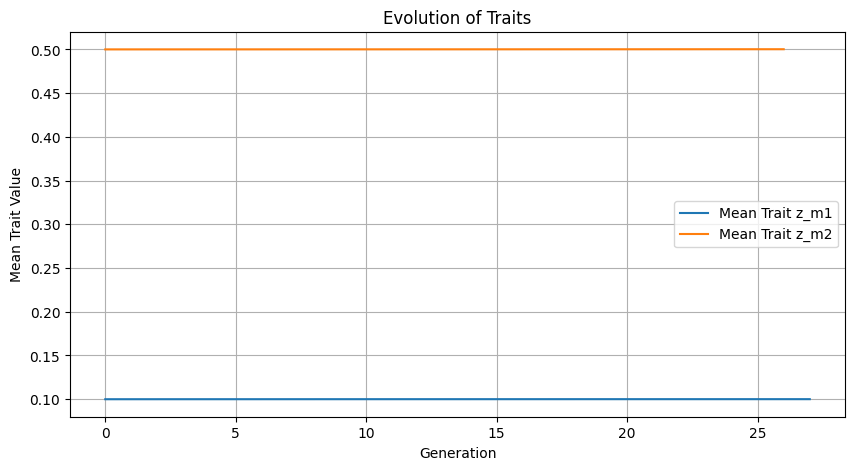

V_A1 = 0.0001 | V_A2 =  0.0001 || generations until extinction =  28


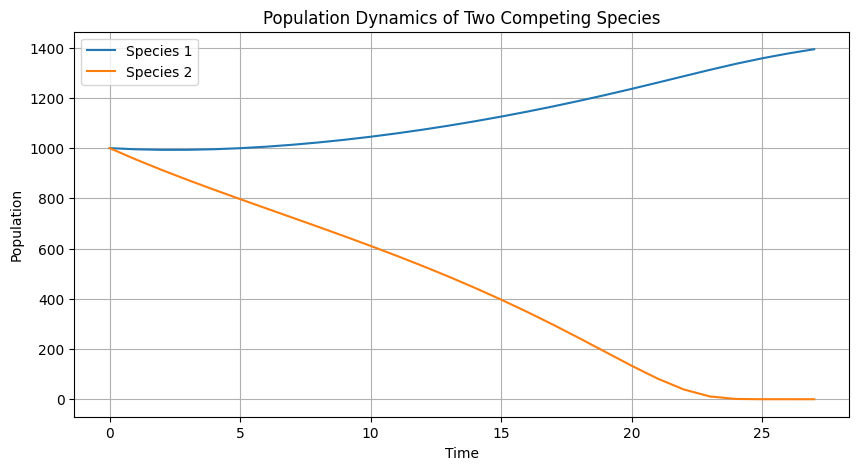

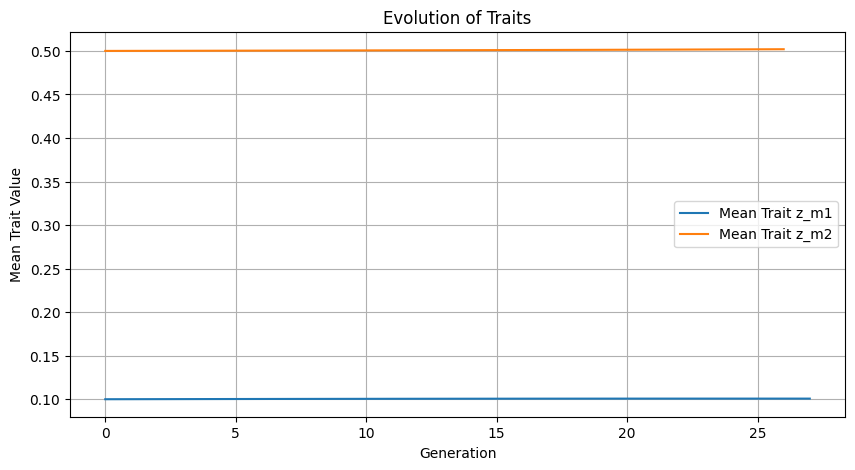

V_A1 = 0.001 | V_A2 =  0.001 || generations until extinction =  28


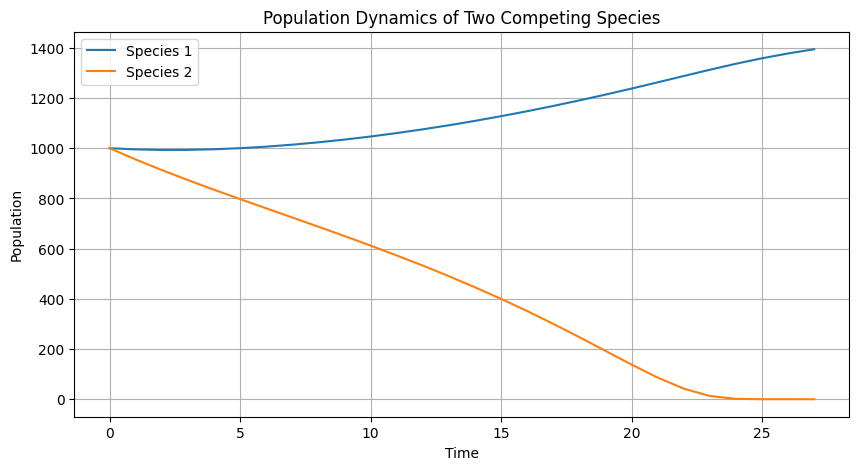

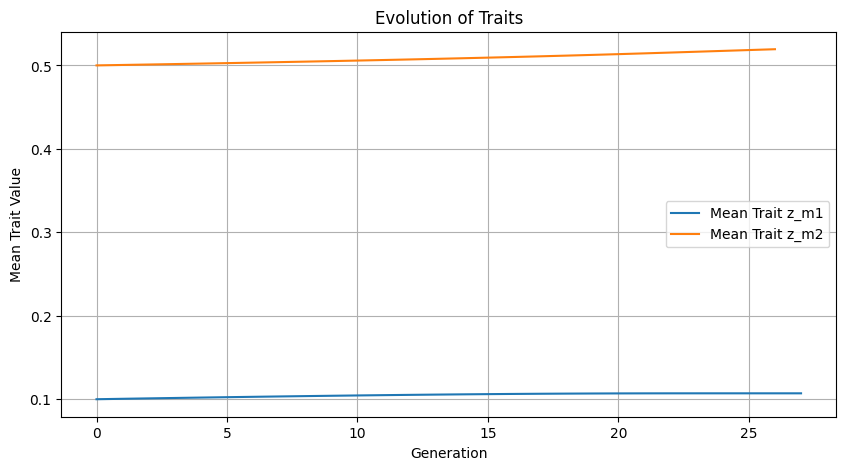

V_A1 = 0.01 | V_A2 =  0.01 || generations until extinction =  28


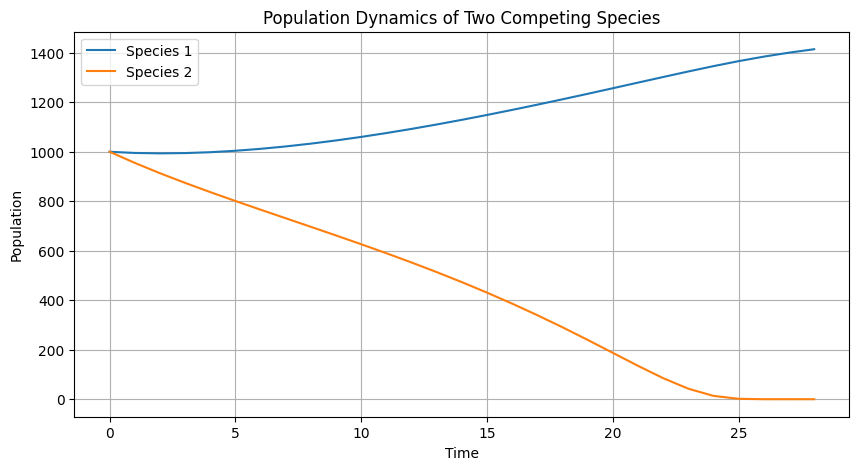

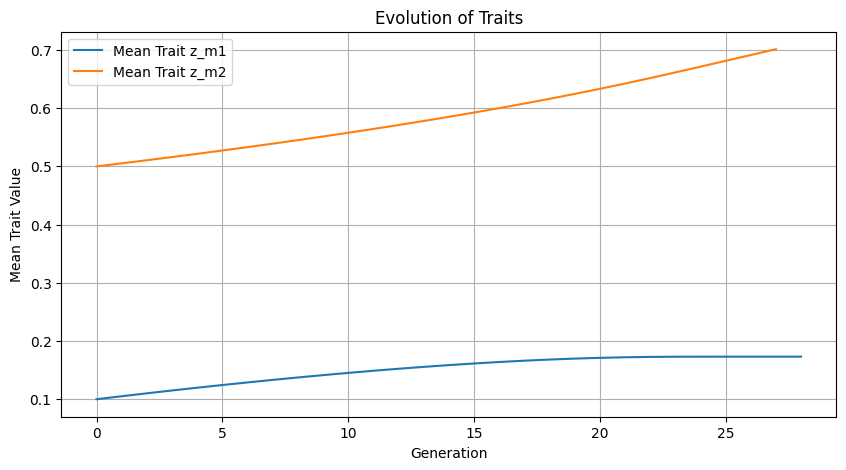

V_A1 = 0.1 | V_A2 =  0.1 || generations until extinction =  29


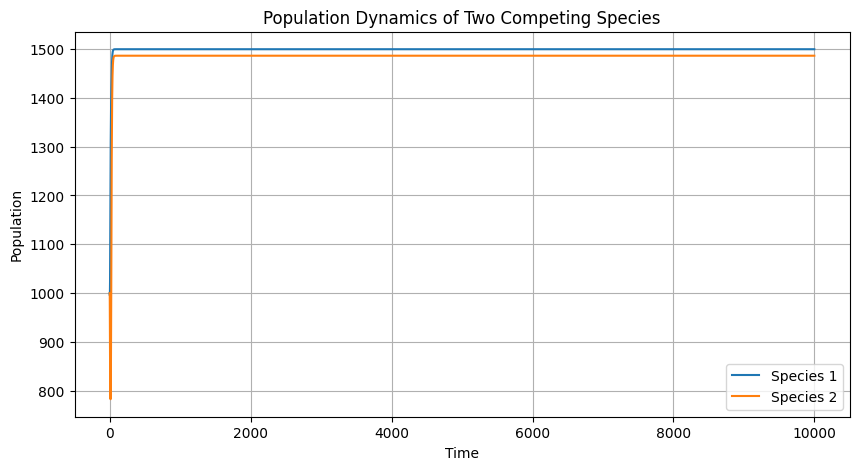

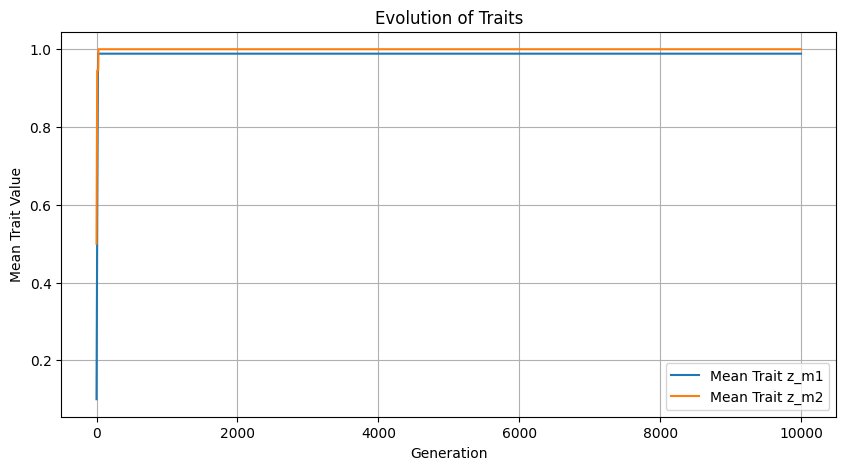

V_A1 = 1 | V_A2 =  1 || generations until extinction =  None


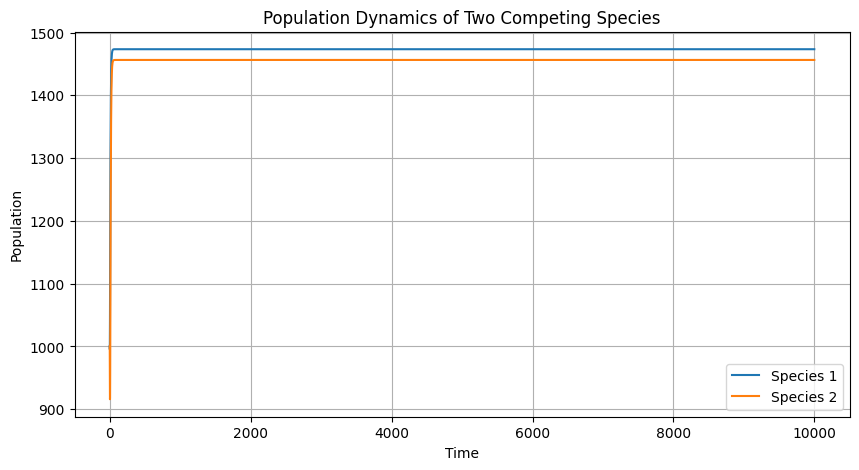

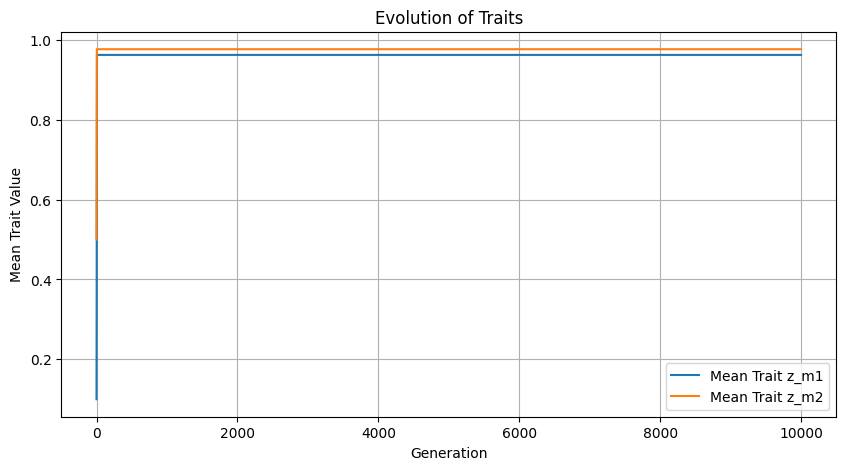

V_A1 = 3 | V_A2 =  3 || generations until extinction =  None


'evolvability sorta reduces the satyr effect as '

In [327]:
'''Positive frequency depednance is a major outcome of reproductive interference, assume both are equal in all respects, evolvabilty, initial discrimination, everything. Only initial number of 1 > 2: How does evolvability of traits '''


'''uninformly increase evolvability of both species ...'''
'''keep z1 as 0 and z2 as 1. Which means z1 has a satry effect on 2 (0 indiscrciminate males), but z2 does not have any effect on 1.'''

evolvability_list = [0, 0.0001, 0.001, 0.01, 0.1, 1, 3]
for evolvability_parameter in evolvability_list:
    params_temp = Parameters(
        b1 = 2.3, 
        b2 = 2.3, 
        k1 = 0.0001, 
        k2 = 0.0001, 
        c12 = 0, 
        c21 = 0, 
        z_m1_initial = 0.1, 
        z_m2_initial = 0.5, 
        initial_population_species_1 = 1000, 
        initial_population_species_2 = 1000, 
        cost_to_males = 0.1,
        strength_of_interference = 0.1,
        V_A1 = evolvability_parameter, 
        V_A2 = evolvability_parameter, 
        num_generations = 10000
    )

    outcome_stats_and_plots_instance_temp = run_simulation_and_get_outcome_instance(params_temp)
    outcome_stats_and_plots_instance_temp.plot_population_dynamics_and_trait_evolution()
    print("V_A1 =", getattr(params_temp, "V_A1" ) ,"|" , "V_A2 = ", getattr(params_temp, "V_A2"), "|| generations until extinction = ", outcome_stats_and_plots_instance_temp.number_of_generations_until_extinctioin)


'''evolution reduces the intensity of satyr effec'''

In [ ]:
'''Assume there is satyr effect initially, z1_initial > z2_initial. If there is no evolvability sp. with higher z will outcomepte the other, Assuming equal evolvability again, how will evolvability modulate this outcome?'''

x_list = [0, 0.01, 0.1, 1]
for x in x_list:
    params_temp = Parameters_for_Analysis(**{ "V_A1" : x}, **{"V_A2" : x}, **{"initial_population_species_1" : 1000}, **{"initial_population_species_2" : 1000})
    outcome_stats_and_plots_instance_temp = run_simulation_and_get_outcome_instance(params_temp)
    # outcome_stats_and_plots_instance_temp.plot_population_dynamics_and_trait_evolution()
    print("V_A1 =", getattr(params_temp, "V_A1" ) ,"|" , "V_A2 = ", getattr(params_temp, "V_A2"), "|| number of generations until extinction = ", outcome_stats_and_plots_instance_temp.number_of_generations_until_extinctioin)



let me test how these senistivity plots work. I will add parameter ranges to the function
define parameter ranges as a dictionary outside. ask chatgpt how I can define parameter as a seperate dictinary. it wil be much easier to gain intution when I do it all together.

Running sensitivity analysis for V_A1...


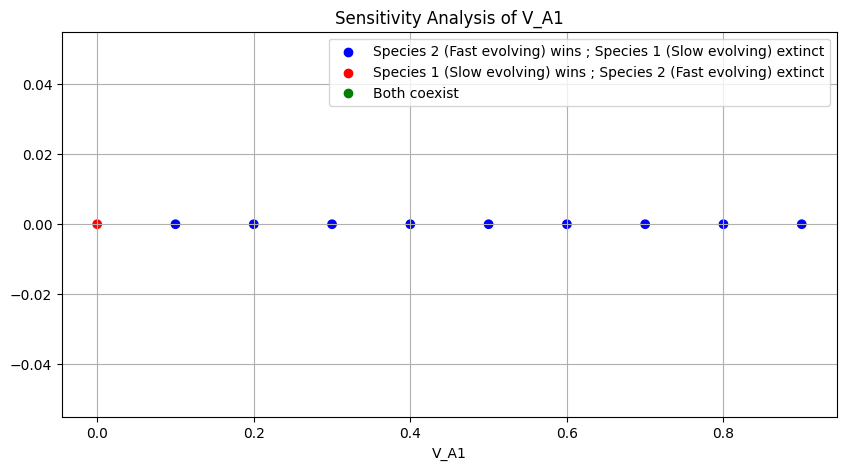

Running sensitivity analysis for V_A2...


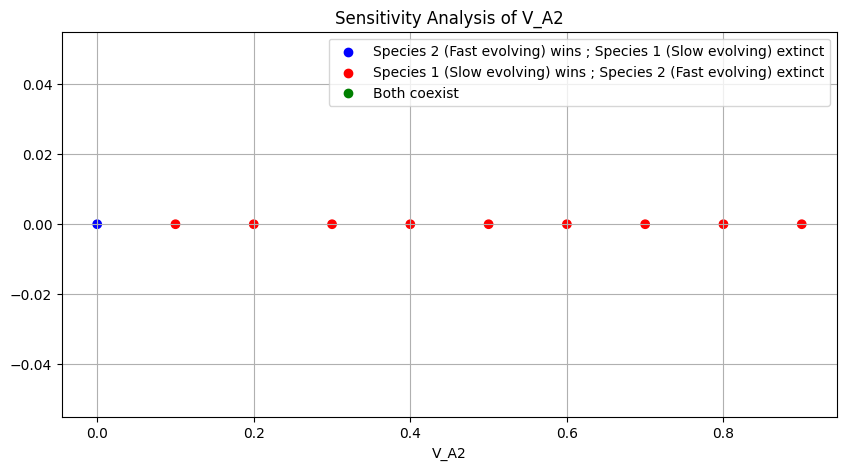

In [308]:
param_names = ['V_A1', 'V_A2']
param_ranges = {
        'z_m1_initial': [0],
        'z_m2_initial': [0.3],
        'V_A1': np.arange(0, 1, 0.1),
        'V_A2': np.arange(0, 1, 0.1)
    }

for param_name in param_names:
    print(f"Running sensitivity analysis for {param_name}...")
    param_values = param_ranges[param_name]
    params_list = generate_parameters_with_varied_param(base_parameters, param_name, param_values)
    outcomes = run_sensitivity_analysis(params_list)
    plot_sensitivity_analysis(param_values, outcomes, param_name)

